In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from typing import Tuple
import optuna


c:\Users\Ricardo Machado\Projetos\ENGA74-TrabalhoFinal\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme(style='whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Leitura e pré-processamento de dados.

In [3]:
df = pd.read_csv('data/Florida NREL 2023.csv', skiprows=2)
df.head(10)

,Year,Month,Day,Hour,Minute,Temperature,Alpha,Aerosol Optical Depth,Asymmetry,Clearsky DHI,...,GHI,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2020,1,1,0,30,12.8,1.43,0.052,0.65,0,...,0,0.249,78.01,113.56,0.92,0.16,1015,1.8,294,1.3
1,2020,1,1,1,30,11.9,1.44,0.048,0.65,0,...,0,0.250,79.01,126.47,0.92,0.16,1015,1.8,294,1.4
2,2020,1,1,2,30,11.3,1.44,0.045,0.65,0,...,0,0.252,79.58,139.58,0.91,0.16,1015,1.8,296,1.4
3,2020,1,1,3,30,10.8,1.43,0.045,0.65,0,...,0,0.252,80.53,152.75,0.92,0.16,1015,1.9,299,1.4
4,2020,1,1,4,30,10.6,1.42,0.046,0.65,0,...,0,0.252,80.77,165.68,0.92,0.16,1015,2.1,302,1.5
5,2020,1,1,5,30,10.6,1.40,0.052,0.65,0,...,0,0.252,80.46,174.60,0.93,0.16,1015,2.2,308,1.6
6,2020,1,1,6,30,10.4,1.41,0.057,0.65,0,...,0,0.252,82.58,165.26,0.93,0.16,1015,2.2,315,1.6
7,2020,1,1,7,30,9.9,1.44,0.055,0.65,0,...,0,0.251,83.70,152.31,0.93,0.16,1014,2.0,323,1.4
8,2020,1,1,8,30,9.4,1.45,0.051,0.65,0,...,0,0.252,85.26,139.13,0.93,0.16,1014,1.9,328,1.4
9,2020,1,1,9,30,9.1,1.45,0.048,0.65,0,...,0,0.252,85.85,126.02,0.92,0.16,1014,1.9,331,1.4


In [4]:
df.describe()

,Year,Month,Day,Hour,Minute,Temperature,Alpha,Aerosol Optical Depth,Asymmetry,Clearsky DHI,...,GHI,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018.528767,6.526027,15.720548,11.500000,30.0,22.692717,1.102733,0.135265,0.632521,51.734132,...,208.807648,0.281050,78.668935,89.730865,0.951562,0.163507,1014.182763,3.341918,163.444292,2.195936
std,3.162002,3.448048,8.796749,6.922582,0.0,6.079356,0.331841,0.079028,0.010915,61.105112,...,290.457856,0.020168,18.847688,41.624641,0.021697,0.009113,4.064898,1.435814,97.836396,1.263986
min,2014.000000,1.000000,1.000000,0.000000,30.0,-0.600000,0.140000,0.021000,0.620000,0.000000,...,0.000000,0.217000,19.010000,5.030000,0.870000,0.140000,1002.000000,0.400000,0.000000,0.200000
25%,2016.000000,4.000000,8.000000,5.750000,30.0,19.000000,0.880000,0.083000,0.620000,0.000000,...,0.000000,0.268000,64.670000,54.382500,0.940000,0.160000,1012.000000,2.200000,83.000000,1.200000
50%,2020.000000,7.000000,16.000000,11.500000,30.0,23.800000,1.170000,0.118000,0.630000,6.000000,...,5.000000,0.281000,82.805000,89.840000,0.960000,0.160000,1014.000000,3.300000,149.000000,1.900000
75%,2021.000000,10.000000,23.000000,17.250000,30.0,27.100000,1.350000,0.166000,0.640000,102.000000,...,399.250000,0.293000,96.122500,125.402500,0.970000,0.170000,1016.000000,4.600000,242.000000,3.000000
max,2023.000000,12.000000,31.000000,23.000000,30.0,35.500000,1.880000,0.736000,0.650000,331.000000,...,1076.000000,0.343000,100.000000,174.850000,0.990000,0.180000,1029.000000,6.900000,360.000000,7.400000


In [5]:
df['Year'].unique()

array([2020, 2014, 2021, 2022, 2017, 2023, 2016])

O banco de dados contém informações para os anos de 2014, 2016, 2017, 2020, 2021, 2022, 2023.

In [6]:
def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(['Minute','Cloud Type', 'Ozone','Solar Zenith Angle', 'Surface Albedo',
                    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'Fill Flag', 'Cloud Fill Flag', 'Aerosol Optical Depth','Alpha','SSA','Asymmetry'], axis = 1)
    df = df.dropna()
    # Combine year, month, day, hour into a single datetime column
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    # Extract useful time-based features
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['HourOfDay'] = df['Datetime'].dt.hour
    df['Month'] = df['Datetime'].dt.month
    # Optionally, drop original columns if not needed
    df = df.drop(['Month', 'Day', 'Hour', 'Datetime'], axis=1)
    return df

In [7]:
def data_scaling_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    scaler = MinMaxScaler()
    columns_to_scale = [col for col in df.columns if col not in ['Year', 'DayOfYear', 'HourOfDay']]
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    # Uso dos dados até 2021 para treino, 2022 para validação e 2023 para teste.
    df_train = df[df['Year'] <= 2021]
    df_val = df[df['Year'] == 2022]
    df_test = df[df['Year'] == 2023]
    #Remove a coluna 'Year' dos dataframes.
    df_train = df_train.drop(['Year'], axis=1)
    df_val = df_val.drop(['Year'], axis=1)
    df_test = df_test.drop(['Year'], axis=1)
    # Reset index for both dataframes
    df_train.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)
    return df_train, df_val, df_test

In [8]:
df = data_preprocessing(df)
df.tail(10)

,Year,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,DayOfYear,HourOfDay
8750,2016,16.7,6.3,385,50.32,1021,1.4,108,2.7,366,14
8751,2016,20.3,8.7,535,47.38,1020,1.6,131,3.7,366,15
8752,2016,22.2,9.6,631,44.78,1019,1.7,141,3.6,366,16
8753,2016,23.3,9.9,660,42.76,1018,1.9,147,3.3,366,17
8754,2016,23.8,9.9,622,41.37,1017,2.0,151,3.2,366,18
8755,2016,23.8,9.8,521,41.00,1016,2.1,152,3.2,366,19
8756,2016,23.2,9.8,367,42.57,1016,2.2,151,2.8,366,20
8757,2016,20.6,10.4,179,52.12,1016,2.2,145,1.9,366,21
8758,2016,17.9,10.8,10,63.11,1017,2.2,138,1.3,366,22
8759,2016,16.8,11.1,0,69.18,1017,2.2,136,1.2,366,23


In [9]:
np.random.seed(42)  # For reproducibility
random_day = np.random.randint(1, 366)
df_random_day = df[df['DayOfYear'] == random_day]
df_random_day = df_random_day.drop(['DayOfYear'], axis=1)
year_of_day = df_random_day["Year"].iloc[0]

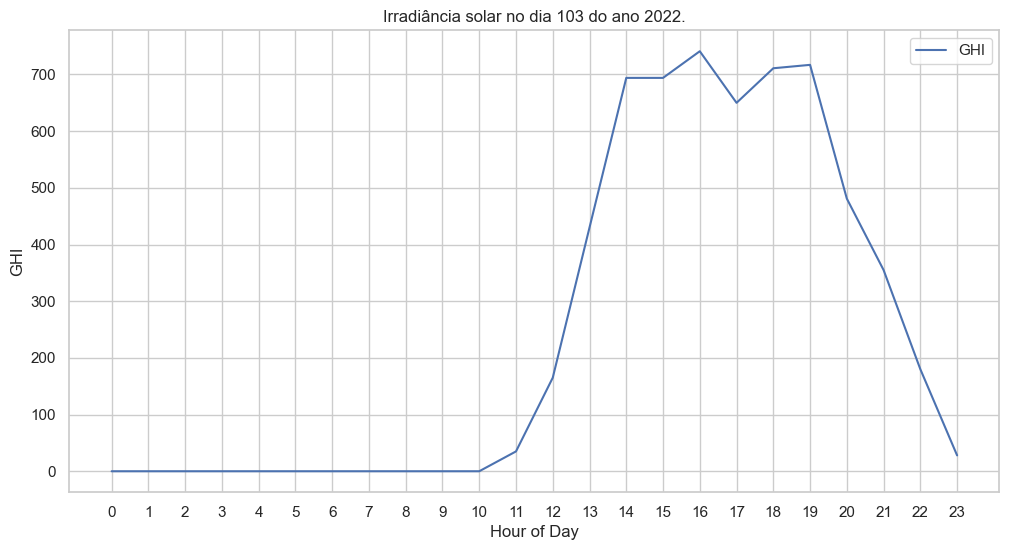

In [10]:
df_random_day.plot(
	x='HourOfDay',
	y='GHI',
	figsize=(12, 6),
	title=f'Irradiância solar no dia {random_day} do ano {year_of_day}.'
)
plt.xlabel('Hour of Day')
plt.ylabel('GHI')
plt.xticks(df_random_day['HourOfDay'])
plt.show()

In [11]:
df_train, df_val, df_test = data_scaling_split(df)


In [12]:
df_test

,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,DayOfYear,HourOfDay
6552,0.731302,0.946176,0.000000,0.998765,0.370370,0.830769,0.147222,0.361111,274,0
6553,0.725762,0.940510,0.000000,1.000000,0.370370,0.815385,0.150000,0.333333,274,1
6554,0.720222,0.934844,0.000000,1.000000,0.370370,0.800000,0.152778,0.305556,274,2
6555,0.717452,0.932011,0.000000,1.000000,0.370370,0.800000,0.152778,0.277778,274,3
6556,0.714681,0.929178,0.000000,1.000000,0.370370,0.800000,0.152778,0.263889,274,4
...,...,...,...,...,...,...,...,...,...,...
7291,0.853186,0.674221,0.534387,0.295345,0.111111,0.400000,0.019444,0.347222,304,19
7292,0.833795,0.660057,0.371747,0.298061,0.111111,0.400000,0.030556,0.333333,304,20
7293,0.783934,0.662890,0.184015,0.363749,0.148148,0.384615,0.058333,0.250000,304,21
7294,0.709141,0.696884,0.018587,0.522534,0.148148,0.369231,0.097222,0.180556,304,22


# Definição dos modelos.

In [13]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Camada GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Camada de saída
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        # Se hidden não for fornecido, inicializa com zeros
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        
        # Passa pela GRU
        out, hidden = self.gru(x, hidden)
        
        # Aplica a camada linear apenas na última saída temporal
        out = self.fc(out[:, -1, :])  # Pega apenas o último timestep
        
        return out
    
    def init_hidden(self, batch_size):
        # Inicializa o estado oculto com zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [14]:
# Implementação de um LSTM simples
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        if hidden is None:
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        else:
            h_0, c_0 = hidden

        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camadas de regularização
        self.dropout1 = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Inicialização dos pesos
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        
        # Pega apenas a última saída da sequência
        out = lstm_out[:, -1, :]
        
        # Regularização e camadas densas
        out = self.dropout1(out)
        out = self.batch_norm(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        
        return out

In [16]:
#Modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camadas de regularização
        self.dropout1 = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Inicialização dos pesos
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        gru_out, _ = self.gru(x)
        
        # Pega apenas a última saída da sequência
        out = gru_out[:, -1, :]
        
        # Regularização e camadas densas
        out = self.dropout1(out)
        out = self.batch_norm(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        
        return out

# Função para treinamento do modelo.

In [17]:
def train_model(model, train_loader, test_loader, epochs, lr, patience=15, weight_decay=1e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

    best_test_loss = float('inf')
    patience_counter = 0
    train_losses = []
    test_losses = []
    best_model_state = None

    for epoch in range(epochs):
        # Treino
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze(-1)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Teste
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss += criterion(outputs.squeeze(), y_batch).item()

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        scheduler.step(test_loss)

        # Early stopping baseado no teste
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping na época {epoch+1}")
                break

        if (epoch + 1) % 20 == 0:
            print(f'Época {epoch+1}/{epochs}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, test_losses, best_test_loss


# Função para plotar as perdas.

In [18]:
def plot_losses(train_losses, test_losses):
    """Plota as perdas de treino e teste """
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Losses durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [19]:
#Convertendo os dados de treino, validação e teste para tensores PyTorch
ghi_values_train = torch.tensor(df_train['GHI'].values, dtype=torch.float32).unsqueeze(-1)
ghi_values_val = torch.tensor(df_val['GHI'].values, dtype=torch.float32).unsqueeze(-1)
ghi_values_test = torch.tensor(df_test['GHI'].values, dtype=torch.float32).unsqueeze(-1)

X_train = ghi_values_train[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_train = ghi_values_train[1:].squeeze(-1)          # shape: (N-1, 1)
X_val = ghi_values_val[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_val = ghi_values_val[1:].squeeze(-1)          # shape: (N-1, 1)
X_test = ghi_values_test[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_test = ghi_values_test[1:].squeeze(-1)          # shape: (N-1, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [21]:
input_size = X_train.shape[-1]
model = SimpleLSTM(input_size=input_size, hidden_size=64, output_size=1).to(device)
train_losses, test_losses, best_test_loss = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15,
    weight_decay=1e-5
)

Época 20/100: Train Loss: 0.011545, Test Loss: 0.014353
Época 40/100: Train Loss: 0.011534, Test Loss: 0.013971
Época 60/100: Train Loss: 0.011470, Test Loss: 0.013933
Early stopping na época 65


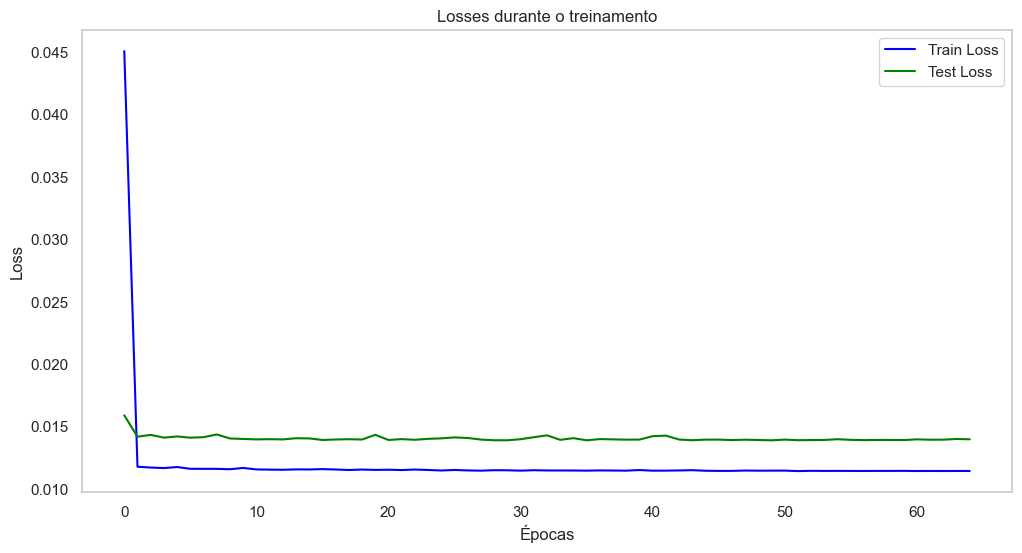

In [22]:
plot_losses(train_losses, test_losses)